# Motivation:

For my CSCI capstone project I am collaborating to develop a moible application that employes computer vision to preform object detection and ideally segmentation on ultrasound images. The objective is to help people in medically disparaged places use the powerful but difficult technology. Some of the limitations imposed on this project were the lack of readily availible electricity and modern computing hardware. Because of this our scope for model complexity is limited to reserve enery draw on phones.

Deep covolutional neural networks, like we have chosen to employ, trade sphicsticated results for large computation time and lack of interpretability. While other methods of statistical analysis or machine learning would struggle to capsture the complexity of the data and underfit they have appeal because of their preformant nature. 


## Problems I will be trying to solve

For my final project I will be preforming a exporatory analysis on a dataset of ultrasound images with two goals in mind(along with their relevant sub-goals):
1. Classify images using non-neural network approaches
	1. Classify images based on the body part being scanned
	2. Classify images as quality scans
2. Search for statistical methods to help assist neural networks classification accuracy
	1. Detect features such as scan depth, general scan quality
	2. Preforming pre-processing on scans
	3. Find correlations between general image features and scan types
	4. Detect anomalies such as a incorrectly preformed scan

# Imports and notebook setup

We will be using industry standard data analsis and machine learning tools to do our exploration. 

## Install and import libraries

In [24]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [25]:
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import cv2
import urllib.request
from tqdm import tqdm
from IPython.display import display, Markdown, Latex, Image

## Dataset Construction

### Downloading Dataset

In [31]:
if not os.path.exists('./data/'):
    LARGE_DATASET_URLS = [
        'https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download'
        '/v.0.0.1/butterfly_dataset_test.tar.gz',
        'https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download'
        '/v.0.0.1/butterfly_dataset_training1.tar.gz',
        'https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download'
        '/v.0.0.1/butterfly_dataset_training2.tar.gz',
    ]
    ! mkdir data
    class ProgressDownload(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)
    for url in LARGE_DATASET_URLS:
        with ProgressDownload(unit='B', unit_scale=True, miniters=1, desc=url) as progress_bar:
            urllib.request.urlretrieve(url, filename='temp.tar.gz', reporthook=progress_bar.update_to)
            ! tar -xzf temp.tar.gz -C data/
            ! rm -f temp.tar.gz

https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download/v.0.0.1/butterfly_dataset_test.tar.gz: 524MB [00:15, 33.5MB/s]                              
https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download/v.0.0.1/butterfly_dataset_training1.tar.gz: 1.52GB [01:23, 18.2MB/s]                               
https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download/v.0.0.1/butterfly_dataset_training2.tar.gz: 1.20GB [01:20, 14.9MB/s]                               


### Unpacking Labels

In [4]:
labels = []
with open('./data/all_list.txt') as file:
    labels = file.read().splitlines()
labels[:]

['Reg-Normal Lung_Example 2_mp4,11',
 'Reg-Normal Lung A lines_mp4,11',
 'Cov-Irregular Pleural Line_Example 2_mp4,12',
 'Cov-Irregular Pleura and Coalescent B-lines_mp4,12',
 'Cov-Irregular Pleura with Multiple B lines_mp4,12',
 'Cov-Irregular Pleural Line_mp4,12',
 'Cov-Irregular Pleura with Confluent B-lines_mp4,12',
 'Cov-Irregular Pleura with Trace Effusion_mp4,12',
 'Cov-Cardiomyopathy_mp4,12',
 'Cov-Confluent B lines_Example 2_mp4,12',
 'Cov-Patchy B lines with Sparing_mp4,12',
 'Cov-Coalescing B lines_mp4,12',
 'Cov-Confluent B lines_mp4,12',
 'Cov-Skip Lesion_mp4,12',
 'Cov-Subpleural Basal Consolidation_mp4,12',
 'Cov-Consolidation_Example 5_mp4,12',
 'Cov-Subpleural Basal Consolidation_Example 2_mp4,12',
 'Cov-Consolidation_Example 2_mp4,12',
 'Cov-Consolidation_Example 4_mp4,12',
 'Cov-Consolidation_mp4,12',
 'Cov-Consolidation_Example 3_mp4,12',
 'Cov-Consolidation with Air Bronchograms_mp4,12']

In [5]:
labels = [label.split('_')[0] for label in labels]
labels[:]

['Reg-Normal Lung',
 'Reg-Normal Lung A lines',
 'Cov-Irregular Pleural Line',
 'Cov-Irregular Pleura and Coalescent B-lines',
 'Cov-Irregular Pleura with Multiple B lines',
 'Cov-Irregular Pleural Line',
 'Cov-Irregular Pleura with Confluent B-lines',
 'Cov-Irregular Pleura with Trace Effusion',
 'Cov-Cardiomyopathy',
 'Cov-Confluent B lines',
 'Cov-Patchy B lines with Sparing',
 'Cov-Coalescing B lines',
 'Cov-Confluent B lines',
 'Cov-Skip Lesion',
 'Cov-Subpleural Basal Consolidation',
 'Cov-Consolidation',
 'Cov-Subpleural Basal Consolidation',
 'Cov-Consolidation',
 'Cov-Consolidation',
 'Cov-Consolidation',
 'Cov-Consolidation',
 'Cov-Consolidation with Air Bronchograms']

In [6]:
labels = list(set(labels))
labels[:]

['Cov-Irregular Pleura and Coalescent B-lines',
 'Cov-Irregular Pleura with Confluent B-lines',
 'Reg-Normal Lung A lines',
 'Cov-Consolidation',
 'Cov-Confluent B lines',
 'Cov-Coalescing B lines',
 'Cov-Irregular Pleura with Trace Effusion',
 'Cov-Irregular Pleura with Multiple B lines',
 'Cov-Cardiomyopathy',
 'Cov-Irregular Pleural Line',
 'Cov-Skip Lesion',
 'Reg-Normal Lung',
 'Cov-Subpleural Basal Consolidation',
 'Cov-Consolidation with Air Bronchograms',
 'Cov-Patchy B lines with Sparing']

### Constructing Data Frame

In [7]:
! tree -L 1 data

data
├── all_list.txt
├── Cov-Cardiomyopathy_mp4
├── Cov-Coalescing B lines_mp4
├── Cov-Confluent B lines_Example 2_mp4
├── Cov-Confluent B lines_mp4
├── Cov-Consolidation_Example 2_mp4
├── Cov-Consolidation_Example 3_mp4
├── Cov-Consolidation_Example 4_mp4
├── Cov-Consolidation_Example 5_mp4
├── Cov-Consolidation_mp4
├── Cov-Consolidation with Air Bronchograms_mp4
├── Cov-Irregular Pleura and Coalescent B-lines_mp4
├── Cov-Irregular Pleural Line_Example 2_mp4
├── Cov-Irregular Pleural Line_mp4
├── Cov-Irregular Pleura with Confluent B-lines_mp4
├── Cov-Irregular Pleura with Multiple B lines_mp4
├── Cov-Irregular Pleura with Trace Effusion_mp4
├── Cov-Patchy B lines with Sparing_mp4
├── Cov-Skip Lesion_mp4
├── Cov-Subpleural Basal Consolidation_Example 2_mp4
├── Cov-Subpleural Basal Consolidation_mp4
├── Reg-Normal Lung A lines_mp4
└── Reg-Normal Lung_Example 2_mp4

23 directories, 1 file


In [8]:
videos = os.listdir('./data/')
videos.remove('all_list.txt')
videos[:]

['Cov-Skip Lesion_mp4',
 'Cov-Subpleural Basal Consolidation_mp4',
 'Cov-Subpleural Basal Consolidation_Example 2_mp4',
 'Cov-Consolidation_Example 5_mp4',
 'Cov-Irregular Pleura with Trace Effusion_mp4',
 'Cov-Irregular Pleural Line_Example 2_mp4',
 'Cov-Consolidation with Air Bronchograms_mp4',
 'Cov-Confluent B lines_mp4',
 'Cov-Irregular Pleural Line_mp4',
 'Reg-Normal Lung A lines_mp4',
 'Cov-Irregular Pleura with Multiple B lines_mp4',
 'Cov-Irregular Pleura with Confluent B-lines_mp4',
 'Cov-Patchy B lines with Sparing_mp4',
 'Cov-Confluent B lines_Example 2_mp4',
 'Cov-Consolidation_Example 4_mp4',
 'Cov-Consolidation_Example 2_mp4',
 'Cov-Consolidation_Example 3_mp4',
 'Reg-Normal Lung_Example 2_mp4',
 'Cov-Cardiomyopathy_mp4',
 'Cov-Coalescing B lines_mp4',
 'Cov-Irregular Pleura and Coalescent B-lines_mp4',
 'Cov-Consolidation_mp4']

In [9]:
df = [["Label", "Image"]]
for video in videos:
    label = video.split('_')[0]
    for image in os.listdir('./data/' + video):
        df.append([label, cv2.imread('./data/' + video + '/' + image)])
df = pd.DataFrame(df[1:], columns=df[0])

# Data Exporation

## Interpreting Data Objects

### General

In [10]:
display(Markdown("#### General Data Information"))
display(df.info())
display(Markdown('#### I\'m not printing a detailed description because it would take forever to run over our images'))

#### General Data Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   1533 non-null   object
 1   Image   1533 non-null   object
dtypes: object(2)
memory usage: 24.1+ KB


None

#### I'm not printing a detailed description because it would take forever to run over our images

### Labels

#### General Information

count                  1533
unique                   15
top       Cov-Consolidation
freq                    391
Name: Label, dtype: object

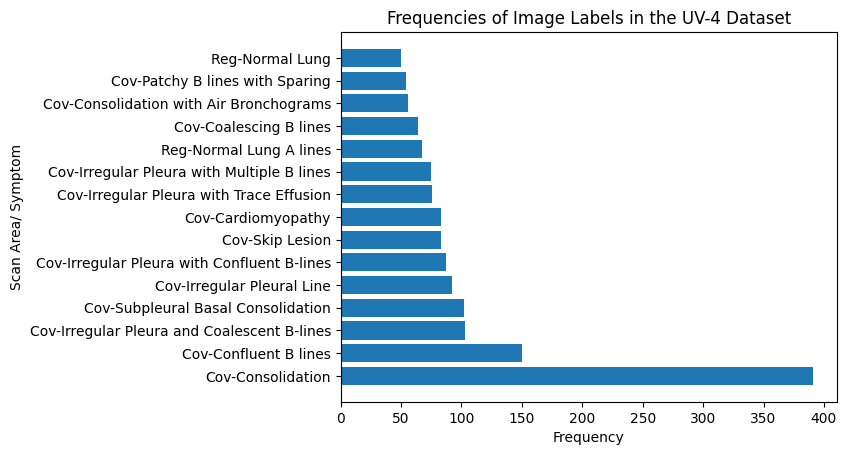

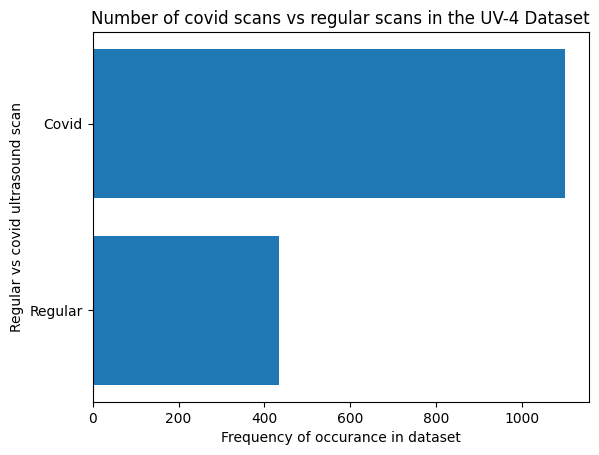

In [11]:
display(Markdown("#### General Information"))
display(df["Label"].describe())

label_counts = df['Label'].value_counts()
plt.barh(label_counts.index, label_counts.values)
plt.ylabel('Scan Area/ Symptom')
plt.xlabel('Frequency')
plt.title("Frequencies of Image Labels in the UV-4 Dataset")
plt.show()
del(label_counts)

n_reg_indexes = sum([label.find('reg') > 0 for label in df['Label']])
plt.barh(['Regular', "Covid"], [n_reg_indexes, len(df['Label']) - n_reg_indexes])
plt.ylabel("Regular vs covid ultrasound scan")
plt.xlabel("Frequency of occurance in dataset")
plt.title("Number of covid scans vs regular scans in the UV-4 Dataset")
plt.show()

### Images

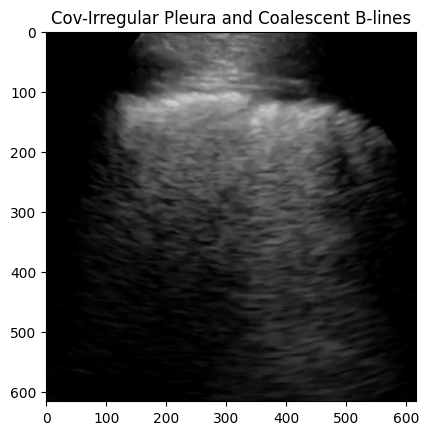

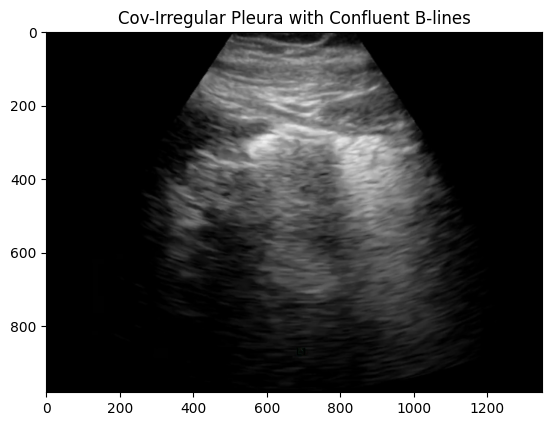

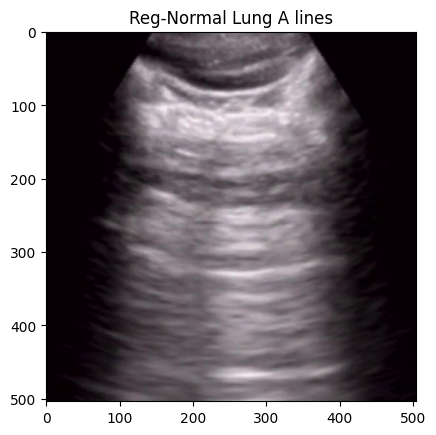

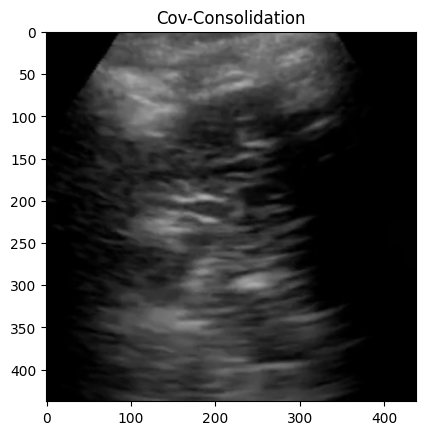

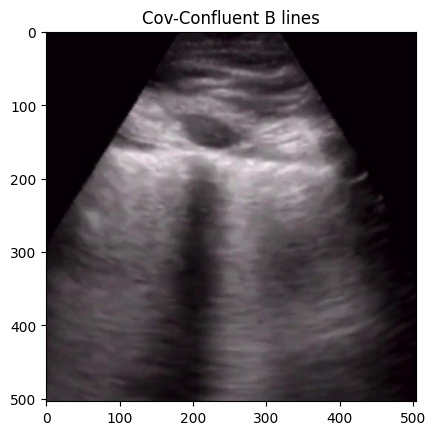

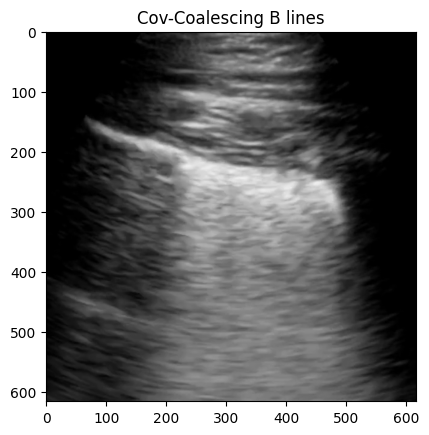

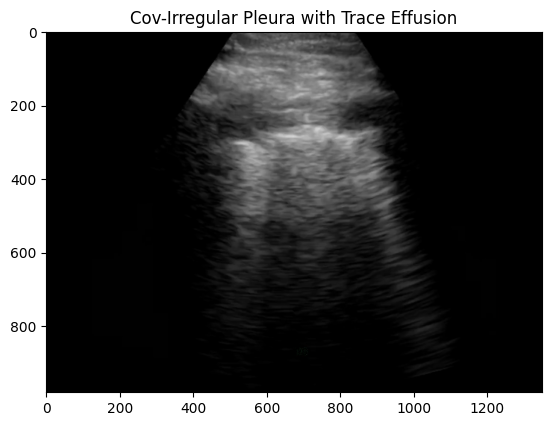

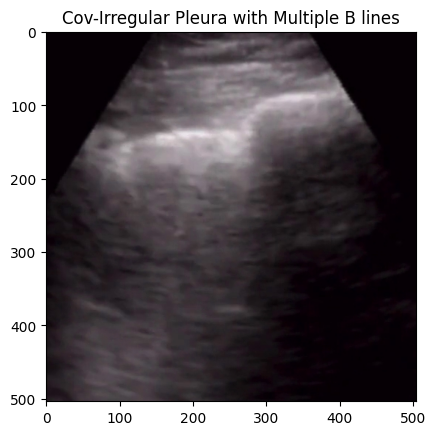

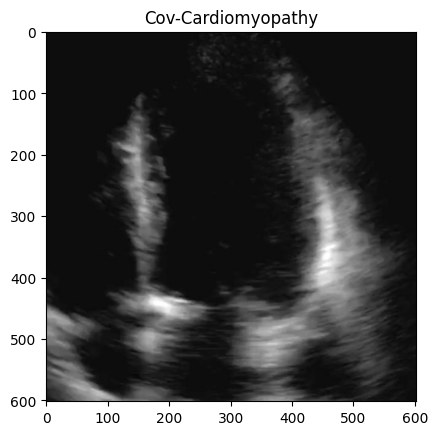

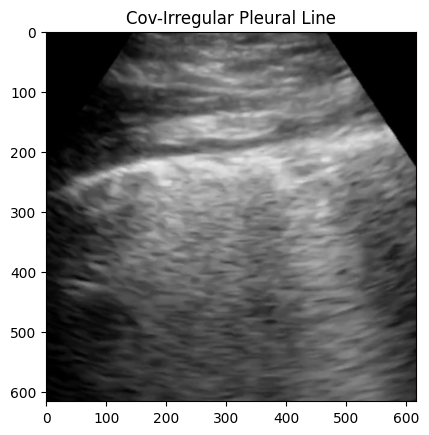

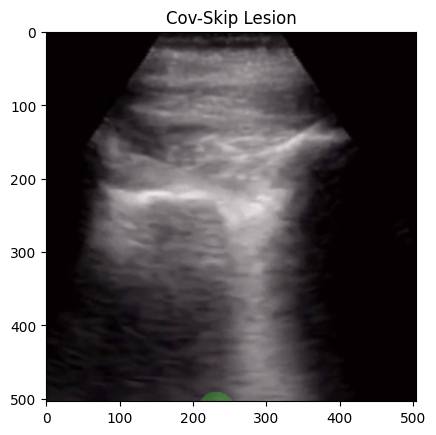

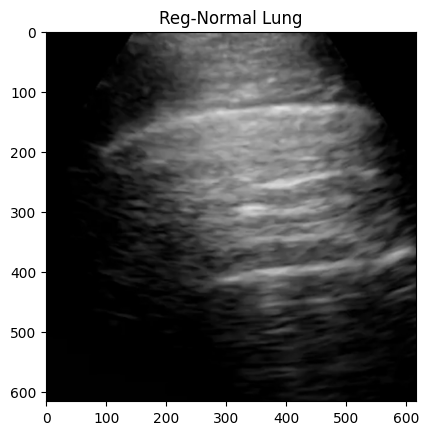

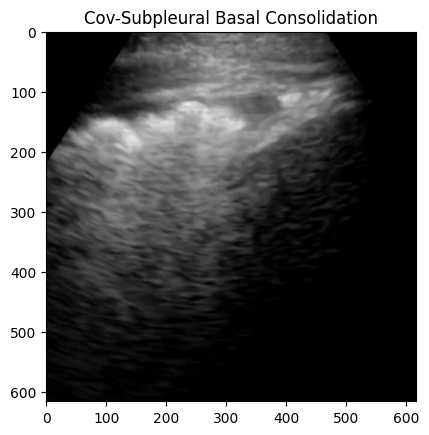

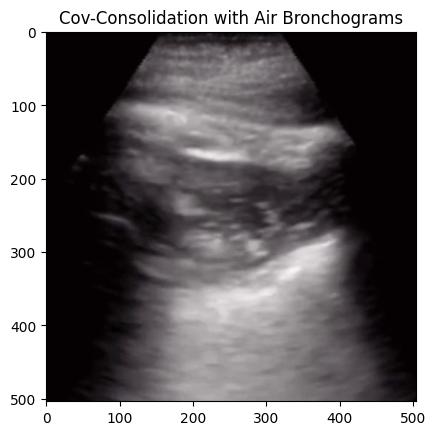

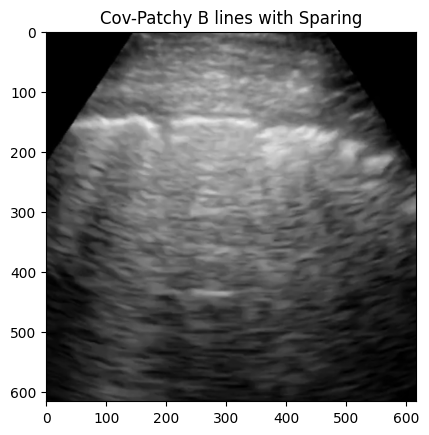

In [18]:
for label in labels:
    plt.imshow(df['Image'][(df['Label'] == label).idxmax()])
    plt.title(label)
    plt.show()

Here are some observations based on the above data: 
1. Not all images are the same size
2. 